In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import *
from sklearn.metrics import roc_curve
from keras.callbacks import EarlyStopping
from keras import backend
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_keras import KerasModelWrapper
import matplotlib as mpl
from keras.models import load_model


Using TensorFlow backend.


## TRAINING ON MNIST DATASET

In [ ]:
SECRET_SEED = 87
(x_train, y_train, x_test, y_test) = get_dataset('mnist')
plt.figure()
plt.imshow(x_train[0,:,:,0])
plt.title('original image')

x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
x_test_shuffle = permute_pixels(x_test, SECRET_SEED)
plt.figure()
plt.imshow(x_train_shuffle[0,:,:,0])
plt.title('permuted image')
plt.show()

In [ ]:
model = get_ppd_model('mnist')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_shuffle, y_train, epochs=5, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test))
model.save('models/mnist_trained_keras_model.hdf5')
print(model.evaluate(x_test_shuffle, y_test))

## TRAINING ON CIFAR10 DATASET

In [ ]:
SECRET_SEED = 87
(x_train, y_train, x_test, y_test) = get_dataset('cifar10')
plt.figure()
plt.imshow(x_train[0])
plt.title('original image')

x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
x_test_shuffle = permute_pixels(x_test, SECRET_SEED)
plt.figure()
plt.imshow(x_train_shuffle[0])
plt.title('permuted image')
plt.show()

In [ ]:
model = get_ppd_model('cifar10')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_shuffle, y_train, epochs=5, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test))
model.save('models/cifar10_trained_keras_model.hdf5')

## Train and Save 10 PPD Models

In [ ]:
for dataset in ['mnist','cifar10']:
    (x_train, y_train, x_test, y_test) = get_dataset(dataset)

    for SECRET_SEED in range(10):
        x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
        x_test_shuffle = permute_pixels(x_test, SECRET_SEED)
        model = get_ppd_model(dataset)
        model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        model.fit(x_train_shuffle, y_train, epochs=5, verbose=2, batch_size=128, validation_data=(x_test_shuffle, y_test))
        model.save('models/'+dataset+'_trained_keras_model_'+str(SECRET_SEED)+'.hdf5')

## Test PPD CNN Model on Cifar10

In [2]:
DATASET_NAME = 'cifar10'
(x_train, y_train, x_test, y_test) = get_dataset(DATASET_NAME)

x_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
x_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [3]:
## JUST CNN

cnn_model = get_cnn_model(name=DATASET_NAME, ppd=False)
cnn_model.summary()
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.fit(x_train, y_train, epochs=25, verbose=1, batch_size=128, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        36928     
__________

In [4]:
## CNN + PPD, SEED 87

SECRET_SEED = 87
x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
x_test_shuffle = permute_pixels(x_test, SECRET_SEED)

ppd_cnn_model = get_cnn_model(name=DATASET_NAME, ppd=True)
ppd_cnn_model.summary()
ppd_cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ppd_cnn_model.fit(x_train_shuffle, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
pixel2phase (Lambda)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [5]:
## CNN + PPD, SEED 23

OTHER_SEED = 23
x_train_shuffle = permute_pixels(x_train, OTHER_SEED)
x_test_shuffle = permute_pixels(x_test, OTHER_SEED)

unknown_model = get_cnn_model(name=DATASET_NAME, ppd=True)
unknown_model.summary()
unknown_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

unknown_model.fit(x_train_shuffle, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
pixel2phase (Lambda)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [6]:
## CNN + phase

phase_cnn_model = get_cnn_model(name=DATASET_NAME, ppd=True)
phase_cnn_model.summary()
phase_cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

phase_cnn_model.fit(x_train, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
pixel2phase (Lambda)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [8]:
## CNN + Permutation, SEED 87

SECRET_SEED = 87
x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
x_test_shuffle = permute_pixels(x_test, SECRET_SEED)

perm_cnn_model = get_cnn_model(name=DATASET_NAME, ppd=False)
perm_cnn_model.summary()
perm_cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

perm_cnn_model.fit(x_train_shuffle, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 64)        36928     
__________

In [10]:
## CNN + Permutation, SEED 23

OTHER_SEED = 23
x_train_shuffle = permute_pixels(x_train, OTHER_SEED)
x_test_shuffle = permute_pixels(x_test, OTHER_SEED)

perm_cnn_model2 = get_cnn_model(name=DATASET_NAME, ppd=False)
perm_cnn_model2.summary()
perm_cnn_model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

perm_cnn_model2.fit(x_train_shuffle, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 15, 15, 64)        36928     
__________

In [12]:
## Get adv from CNN, CNN+PPD (87), CNN + Phase, CNN + Perm (87)

sess =  backend.get_session()
backend.set_learning_phase(False)
attack_params = {
    'eps': 0.4
    }

def get_adv_exapmles(model, x, sess, attack_params):
    wrap = KerasModelWrapper(model)
    attack_model = FastGradientMethod(wrap, sess=sess)
    x_adv = attack_model.generate_np(x, **attack_params)
    return x_adv

x_adv_cnn = get_adv_exapmles(cnn_model, x_test, sess, attack_params)
x_adv_phase = get_adv_exapmles(phase_cnn_model, x_test, sess, attack_params)
x_adv_perm = get_adv_exapmles(perm_cnn_model, x_test, sess, attack_params)
x_adv_ppd = get_adv_exapmles(ppd_cnn_model, x_test, sess, attack_params)

In [13]:
## Test cnn_adv on cnn, test cnn+ppd (87) adv on cnn+ppd (87) and cnn+ppd (23)

def test_model(model, x, y):
    pred = np.argmax(model.predict(x), axis = 1)
    acc =  np.mean(np.equal(pred.reshape(y.shape), y))
    return (pred, acc)

pred, acc = test_model(cnn_model, x_test, y_test)
print ('CNN acc normally', acc)
pred, acc = test_model(cnn_model, x_adv_cnn, y_test)
print ('CNN acc adv', acc)

pred, acc = test_model(phase_cnn_model, x_test, y_test)
print ('Phase CNN acc normally', acc)
pred, acc = test_model(phase_cnn_model, x_adv_phase, y_test)
print ('Phase CNN acc adv', acc)

x_shuffle = permute_pixels(x_test, SECRET_SEED)
x_adv_shuffle = permute_pixels(x_adv_perm, SECRET_SEED)

pred, acc = test_model(perm_cnn_model, x_shuffle, y_test)
print ('Perm CNN known seed acc normally', acc)
pred, acc = test_model(perm_cnn_model, x_adv_shuffle, y_test)
print ('Perm CNN known seed acc adv', acc)

x_shuffle = permute_pixels(x_test, OTHER_SEED)
x_adv_shuffle = permute_pixels(x_adv_perm, OTHER_SEED)

pred, acc = test_model(perm_cnn_model2, x_shuffle, y_test)
print ('Perm CNN hidden seed acc normally', acc)
pred, acc = test_model(perm_cnn_model2, x_adv_shuffle, y_test)
print ('Perm CNN hidden seed acc normally', acc)

x_shuffle = permute_pixels(x_test, SECRET_SEED)
x_adv_shuffle = permute_pixels(x_adv_ppd, SECRET_SEED)

pred, acc = test_model(ppd_cnn_model, x_shuffle, y_test)
print ('PPD CNN acc normally', acc)
pred, acc = test_model(ppd_cnn_model, x_adv_shuffle, y_test)
print ('PPD CNN acc adv', acc)

x_shuffle = permute_pixels(x_test, OTHER_SEED)
x_adv_shuffle = permute_pixels(x_adv_ppd, OTHER_SEED)

pred, acc = test_model(unknown_model, x_shuffle, y_test)
print ('PPD CNN with secret seed normally acc', acc)
pred, acc = test_model(unknown_model, x_adv_shuffle, y_test)
print ('PPD CNN with secret seed adv acc', acc)

CNN acc normally 0.7861
CNN acc adv 0.136
Phase CNN acc normally 0.5764
Phase CNN acc adv 0.2084
Perm CNN known seed acc normally 0.5247
Perm CNN known seed acc adv 0.1413
Perm CNN hidden seed acc normally 0.5313
Perm CNN hidden seed acc normally 0.1508
PPD CNN acc normally 0.4153
PPD CNN acc adv 0.2154
PPD CNN with secret seed normally acc 0.4218
PPD CNN with secret seed adv acc 0.2043


In [14]:
## MLP 
mlp_model = get_ppd_model(name=DATASET_NAME, ppd=False)
mlp_model.summary()
mlp_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

mlp_model.fit(x_train, y_train, epochs=25, verbose=1, batch_size=128, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense800 (Dense)             (None, 800)               2458400   
_________________________________________________________________
dense300 (Dense)             (None, 300)               240300    
_________________________________________________________________
dense10 (Dense)              (None, 10)                3010      
Total params: 2,701,710
Trainable params: 2,701,710
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.9

In [15]:
## MLP + phase

phase_model = get_ppd_model(name=DATASET_NAME, ppd=True)
phase_model.summary()
phase_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

phase_model.fit(x_train, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
pixel2phase (Lambda)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense800 (Dense)             (None, 800)               2458400   
_________________________________________________________________
dense300 (Dense)             (None, 300)               240300    
_________________________________________________________________
dense10 (Dense)              (None, 10)                3010      
Total params: 2,701,710
Trainable params: 2,701,710
Non-trainable params: 0
_________________________________________________________________


In [16]:
## MLP + Permutation (seed 87)
SECRET_SEED = 87
x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
x_test_shuffle = permute_pixels(x_test, SECRET_SEED)

perm_model = get_ppd_model(name=DATASET_NAME, ppd=False)
perm_model.summary()
perm_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

perm_model.fit(x_train_shuffle, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense800 (Dense)             (None, 800)               2458400   
_________________________________________________________________
dense300 (Dense)             (None, 300)               240300    
_________________________________________________________________
dense10 (Dense)              (None, 10)                3010      
Total params: 2,701,710
Trainable params: 2,701,710
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.9

In [17]:
## MLP + Permutation (seed 23)
OTHER_SEED = 23
x_train_shuffle = permute_pixels(x_train, OTHER_SEED)
x_test_shuffle = permute_pixels(x_test, OTHER_SEED)

perm_model2 = get_ppd_model(name=DATASET_NAME, ppd=False)
perm_model2.summary()
perm_model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

perm_model2.fit(x_train_shuffle, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense800 (Dense)             (None, 800)               2458400   
_________________________________________________________________
dense300 (Dense)             (None, 300)               240300    
_________________________________________________________________
dense10 (Dense)              (None, 10)                3010      
Total params: 2,701,710
Trainable params: 2,701,710
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.9

In [18]:
## MLP + PPD (seed 87)

SECRET_SEED = 87
x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
x_test_shuffle = permute_pixels(x_test, SECRET_SEED)

ppd_mlp_model = get_ppd_model(name=DATASET_NAME, ppd=True)
ppd_mlp_model.summary()
ppd_mlp_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ppd_mlp_model.fit(x_train_shuffle, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
pixel2phase (Lambda)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense800 (Dense)             (None, 800)               2458400   
_________________________________________________________________
dense300 (Dense)             (None, 300)               240300    
_________________________________________________________________
dense10 (Dense)              (None, 10)                3010      
Total params: 2,701,710
Trainable params: 2,701,710
Non-trainable params: 0
_________________________________________________________________


In [19]:
## MLP + PPD (seed 23)

OTHER_SEED = 23
x_train_shuffle = permute_pixels(x_train, OTHER_SEED)
x_test_shuffle = permute_pixels(x_test, OTHER_SEED)

other_model = get_ppd_model(name=DATASET_NAME, ppd=True)
other_model.summary()
other_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

other_model.fit(x_train_shuffle, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
pixel2phase (Lambda)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense800 (Dense)             (None, 800)               2458400   
_________________________________________________________________
dense300 (Dense)             (None, 300)               240300    
_________________________________________________________________
dense10 (Dense)              (None, 10)                3010      
Total params: 2,701,710
Trainable params: 2,701,710
Non-trainable params: 0
_________________________________________________________________


In [20]:
sess =  backend.get_session()
backend.set_learning_phase(False)
attack_params = {
    'eps': 0.4
    }

def get_adv_exapmles(model, x, sess, attack_params):
    wrap = KerasModelWrapper(model)
    attack_model = FastGradientMethod(wrap, sess=sess)
    x_adv = attack_model.generate_np(x, **attack_params)
    return x_adv

x_adv_mlp = get_adv_exapmles(mlp_model, x_test, sess, attack_params)
x_adv_phase = get_adv_exapmles(phase_model, x_test, sess, attack_params)
x_adv_perm = get_adv_exapmles(perm_model, x_test, sess, attack_params)
x_adv_ppd = get_adv_exapmles(ppd_mlp_model, x_test, sess, attack_params)

In [22]:
def test_model(model, x, y):
    pred = np.argmax(model.predict(x), axis = 1)
    acc =  np.mean(np.equal(pred.reshape(y.shape), y))
    return (pred, acc)

pred, acc = test_model(mlp_model, x_test, y_test)
print ('MLP acc normally', acc)
pred, acc = test_model(mlp_model, x_adv_mlp, y_test)
print ('MLP acc adv', acc)

pred, acc = test_model(phase_model, x_test, y_test)
print ('Phase MLP acc normally', acc)
pred, acc = test_model(phase_model, x_adv_phase, y_test)
print ('Phase MLP acc adv', acc)

x_shuffle = permute_pixels(x_test, SECRET_SEED)
x_adv_shuffle = permute_pixels(x_adv_perm, SECRET_SEED)

pred, acc = test_model(perm_model, x_shuffle, y_test)
print ('Perm MLP acc normally', acc)
pred, acc = test_model(perm_model, x_adv_shuffle, y_test)
print ('Perm MLP acc adv', acc)

x_shuffle = permute_pixels(x_test, OTHER_SEED)
x_adv_shuffle = permute_pixels(x_adv_perm, OTHER_SEED)

pred, acc = test_model(perm_model2, x_shuffle, y_test)
print ('Perm MLP hidden seed acc normally', acc)
pred, acc = test_model(perm_model2, x_adv_shuffle, y_test)
print ('Perm MLP hidden seed acc adv', acc)

x_shuffle = permute_pixels(x_test, SECRET_SEED)
x_adv_shuffle = permute_pixels(x_adv_ppd, SECRET_SEED)

pred, acc = test_model(ppd_mlp_model, x_shuffle, y_test)
print ('PPD MLP acc normally', acc)
pred, acc = test_model(ppd_mlp_model, x_adv_shuffle, y_test)
print ('PPD MLP acc adv', acc)

x_shuffle = permute_pixels(x_test, OTHER_SEED)
x_adv_shuffle = permute_pixels(x_adv_ppd, OTHER_SEED)

pred, acc = test_model(other_model, x_shuffle, y_test)
print ('PPD MLP hidden seed acc normally', acc)
pred, acc = test_model(other_model, x_adv_shuffle, y_test)
print ('PPD MLP hidden seed acc adv', acc)

MLP acc normally 0.5158
MLP acc adv 0.0813
Phase MLP acc normally 0.2707
Phase MLP acc adv 0.1935
Perm MLP acc normally 0.4937
Perm MLP acc adv 0.304
Perm MLP hidden seed acc normally 0.5117
Perm MLP hidden seed acc adv 0.3089
PPD MLP acc normally 0.4521
PPD MLP acc adv 0.2312
PPD MLP hidden seed acc normally 0.4584
PPD MLP hidden seed acc adv 0.2499


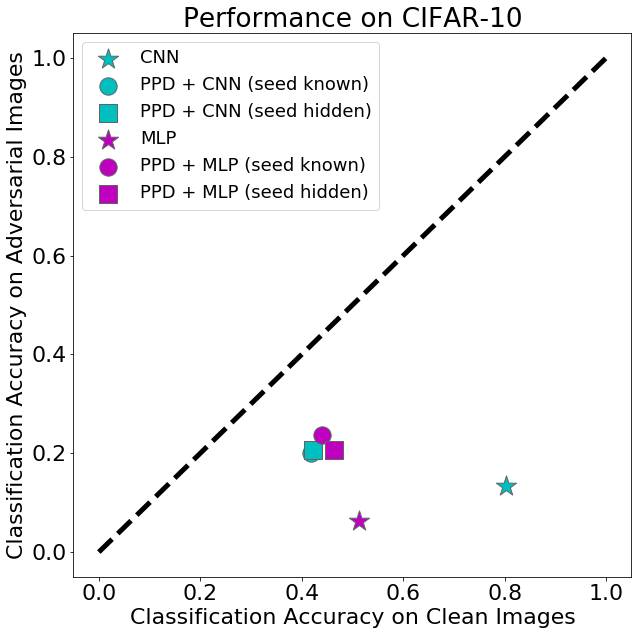

In [25]:
plt.figure(0, figsize=(10, 10))
mpl.rcParams.update({'font.size': 22})

plt.plot([0, 1], [0, 1], 'k--', linewidth=5)
plt.scatter([0.803],[0.1338], s=450, marker='*', color='c', label='CNN', edgecolor='#616366')
plt.scatter([0.4185],[0.2013], s=300, marker='o', color='c', label='PPD + CNN (seed known)', edgecolor='#616366')
plt.scatter([0.4232],[0.2061], s=300, marker='s', color='c', label='PPD + CNN (seed hidden)', edgecolor='#616366')

plt.scatter([0.5138],[0.0625], s=450, marker='*', color='m', label='MLP', edgecolor='#616366')
plt.scatter([0.4394],[0.236], s=300, marker='o', color='m', label='PPD + MLP (seed known)', edgecolor='#616366')
plt.scatter([0.4634],[0.2061], s=300, marker='s', color='m', label='PPD + MLP (seed hidden)', edgecolor='#616366')

plt.xlabel('Classification Accuracy on Clean Images')
plt.ylabel('Classification Accuracy on Adversarial Images')
plt.title('Performance on CIFAR-10')
plt.legend(fontsize=18)
plt.savefig('performance.pdf', bbox_inches='tight')

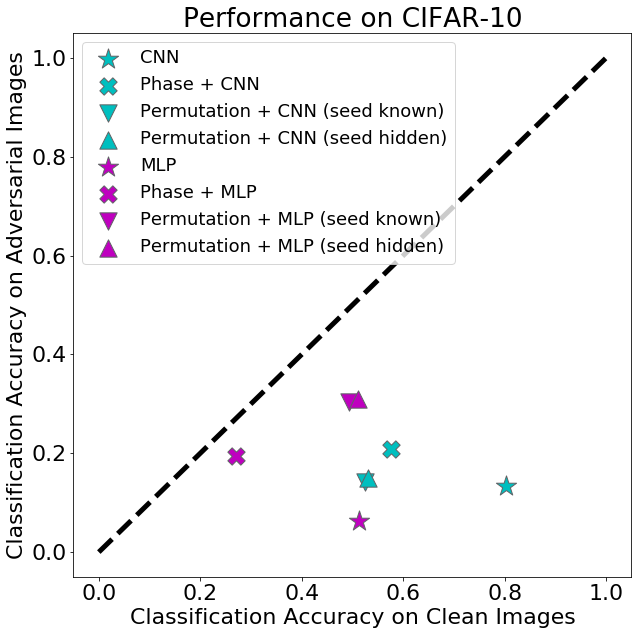

In [26]:
plt.figure(0, figsize=(10, 10))
mpl.rcParams.update({'font.size': 22})

plt.plot([0, 1], [0, 1], 'k--', linewidth=5)
plt.scatter([0.803],[0.1338], s=450, marker='*', color='c', label='CNN', edgecolor='#616366')
plt.scatter([0.5764],[0.2084], s=300, marker='X', color='c', label='Phase + CNN', edgecolor='#616366')
plt.scatter([0.5247],[0.1413], s=300, marker='v', color='c', label='Permutation + CNN (seed known)', edgecolor='#616366')
plt.scatter([0.5313],[0.1508], s=300, marker='^', color='c', label='Permutation + CNN (seed hidden)', edgecolor='#616366')

plt.scatter([0.5138],[0.0625], s=450, marker='*', color='m', label='MLP', edgecolor='#616366')
plt.scatter([0.2707],[0.1935], s=300, marker='X', color='m', label='Phase + MLP', edgecolor='#616366')
plt.scatter([0.4937],[0.304], s=300, marker='v', color='m', label='Permutation + MLP (seed known)', edgecolor='#616366')
plt.scatter([0.5117],[0.3089], s=300, marker='^', color='m', label='Permutation + MLP (seed hidden)', edgecolor='#616366')

plt.xlabel('Classification Accuracy on Clean Images')
plt.ylabel('Classification Accuracy on Adversarial Images')
plt.title('Performance on CIFAR-10')
plt.legend(fontsize=18)
plt.savefig('performance_breakdown.pdf', bbox_inches='tight')